In [1]:
import random
import cupy as cp

In [2]:
class MLP:

    """
    MLP 回归算法
    """
    
    def __init__(
            self,
            hidden_size_list: list = []
    ):        
        
        """
        初始化 MLP 回归算法

        Parameters
        ----------
        hidden_size_list : 隐层规模及对应维度
        """
        
        self.hidden_size_list = hidden_size_list

    def shuffle(
            self,
            X: cp.ndarray = None,
            y: cp.ndarray = None,
            random_seed: int = 0
    ) -> tuple[cp.ndarray, cp.ndarray]:
        
        """
        将原始数据集进行随机排序

        Parameters
        ----------
        X : 训练数据集的特征集
        y : 训练数据集的标签集
        random_seed : 随机种子

        Returns
        -------
        X : 训练数据集重排序后的特征集
        y : 训练数据集重排序后的标签集
        """
        
        random.seed(random_seed)
        index = cp.arange(len(X))
        random.shuffle(index)
        X = X[index]
        y = y[index]

        return X, y
    
    def activate_function(
            self,
            X: cp.ndarray = None
    ) -> cp.ndarray:

        """
        激活函数

        Parameters
        ----------
        X : 特征数据集

        Returns
        -------
        value : 对特征数据进行非线性变换后的取值
        """
        
        if self.activate_func == "sigmoid":
            value = 1 / (1 + cp.exp( - X))
        
        elif self.activate_func == "tanh":
            value = (cp.exp(X) - cp.exp( - X)) / (cp.exp(X) + cp.exp( - X))

        elif self.activate_func == "relu":
            value = cp.where(X > 0, X, 0)

        return value
    
    def gradient(
            self,
            X: cp.ndarray = None
    ) -> cp.ndarray:
        
        """
        激活函数的梯度

        Parameters
        ----------
        X : 特征数据集

        Returns
        -------
        value : 特征数据对应激活函数的梯度值
        """
        
        if self.activate_func == "sigmoid":
            value = X * (1 - X)
        
        elif self.activate_func == "tanh":
            value = 1 - X ** 2

        elif self.activate_func == "relu":
            value = cp.where(X > 0, 1, 0)

        return value
    
    def fit(
            self,
            X: cp.ndarray = None,
            Y: cp.ndarray = None,
            lr: float = 0.1,
            activate_func: str = "sigmoid",
            batch_size: int = 128,
            epoch_num: int = 100,
            random_seed: int = 0
    ):
        
        """
        拟合训练数据集

        Parameters
        ----------
        X : 训练数据集的特征集
        y : 训练数据集的标签集
        lr : 学习率
        activate_func : 激活函数的类型，可取 "sigmoid"、"tanh" 或 "relu"
        batch_size : 随机梯度下降法更新参数时每一批数据集包含的数据量
        epoch_num : 迭代次数
        random_seed : 随机数种子
        """
        
        self.activate_func = activate_func

        Y = Y.reshape(-1, 1)
        # 训练数据集重排序
        X, Y = self.shuffle(X, Y, random_seed)
        
        self.loss = list()
        
        # 初始化每层隐层的参数后传入 hidden_layer_state
        self.hidden_layer_state = list()
        dim = X.shape[1]
        
        for hidden_size in self.hidden_size_list:
            
            hidden_layer_weight = cp.random.normal(0, 1, (hidden_size, dim))
            hidden_layer_bais = cp.random.normal(0, 1, hidden_size)

            self.hidden_layer_state.append([hidden_layer_weight, hidden_layer_bais])
            dim = hidden_size

        # 拟合训练数据，采用随机梯度下降法更新算法参数
        batch_num = len(X) // batch_size
        X = cp.array_split(X, batch_num)
        Y = cp.array_split(Y, batch_num)
        
        epoch = 0
        while True:
            
            loss = 0
            for x, y in zip(X, Y):
                
                # 输出层的 delta
                delta = self.predict(x) - y
                
                # 反向更新第 i 层隐层的参数
                for i in range(len(self.hidden_layer_state) - 1, -1, -1):
                    
                    # 前向传播计算第 i 层隐层的输出
                    hidden_out = self.predict(x, i)
                    hidden_out = cp.expand_dims(hidden_out, axis = 1)
                    
                    # 计算参数矩阵和偏置
                    bais_grad = cp.mean(delta, axis = 0)
                    delta = cp.expand_dims(delta, axis = 2)
                    weight_grad = cp.mean(delta * hidden_out, axis = 0)
                        
                    hidden_out = hidden_out.squeeze(1)
                    delta = delta.squeeze(2)

                    hidden_state = self.hidden_layer_state[i]
                    hidden_layer_weight = hidden_state[0]
                    hidden_layer_bais = hidden_state[1]
                    
                    # 更新第 i 层隐层的参数
                    hidden_layer_weight -= lr * weight_grad
                    hidden_layer_bais -= lr * bais_grad

                    hidden_state = [hidden_layer_weight, hidden_layer_bais]

                    self.hidden_layer_state[i] = hidden_state
                    
                    # 更新 delta 得到第 i - 1 层的 delta
                    A = self.gradient(hidden_out)
                    B: cp.ndarray = delta @ hidden_layer_weight
                    delta: cp.ndarray = B.T * A.T
                    delta = delta.T

                loss += self.eval(x, y)

            self.loss.append(loss / batch_num)

            epoch += 1

            if epoch == epoch_num:
                break

    def predict(
            self,
            X: cp.ndarray = None,
            layer_num: int = None
    ) -> cp.ndarray:
        
        """
        利用 MLP 神经网络进行预测

        Parameters
        ----------
        X : 特征数据集
        layer_num : 将第 layer_num 层隐层视为输出层时的预测情况

        Returns
        -------
        hidden_out : 算法预测值
        """
        
        total_layer_num = len(self.hidden_size_list)
        
        if layer_num is None:
            layer_num = total_layer_num
        
        hidden_out = X

        for i in range(layer_num):
            hidden_state = self.hidden_layer_state[i]
            
            hidden_layer_weight: cp.ndarray = hidden_state[0]
            hidden_layer_bais = hidden_state[1]
            z = hidden_out @ hidden_layer_weight.T + hidden_layer_bais

            if i < layer_num - 1:
                hidden_out = self.activate_function(z)
            else:
                hidden_out = z

        return hidden_out
    
    def eval(
            self,
            X: cp.ndarray = None,
            y: cp.ndarray = None
    ) -> float:
        
        """
        评估函数，评估损失函数值

        Paramters
        ---------
        X : 数据集的特征集
        y : 数据集的标签集

        Returns
        -------
        loss : 损失函数值
        """
        
        loss = cp.mean(1 / 2 * (y - self.predict(X)) ** 2).get()
        return loss

In [3]:
import pandas as pd
from joblib import Parallel, delayed

In [4]:
def zscore(
        x: pd.DataFrame
) -> pd.DataFrame:
    
    """
    数据标准化

    Parameters
    ----------
    X : 特征数据集

    Returns
    -------
    返回标准化数据
    """
    
    x = (x - x.mean(axis = 0)) / (x.std(axis = 0, ddof = 1) + 1e-5)
    return x

# 读取数据，该数据为 ETF 因子数据和收益率数据，总共包含了 60 个因子
data = pd.read_csv("./data.csv", index_col = ["code", "date"])
data.dropna(inplace = True)
ret = data.iloc[:, -1]

# 将数据进行标准化
groups = data.groupby("date")
data = Parallel(n_jobs = -1)(delayed(zscore)(group) for _, group in groups)
data: pd.DataFrame = pd.concat(data)

start_date = "2020-01-01"
split_date = "2024-01-01"
end_date = "2024-12-31"
date_index = data.reset_index(level = 0).index
train_data = data[(date_index >= start_date) & (date_index < split_date)]
valid_data = data[date_index >= split_date]

# 拆分训练集和验证集
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1][X_train.index]
X_valid = valid_data.iloc[:, :-1]
y_valid = valid_data.iloc[:, -1][X_valid.index]

X_train.head(5)


,,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60
code,date,,,,,,,,,,,,,,,,,,,,,
159901,2020-01-02,-0.299198,-0.276981,0.055952,1.311973,-0.423774,-0.455034,0.469523,0.273358,0.115936,-0.218295,...,-0.405065,-0.069256,-0.294745,-0.216171,0.825148,0.016485,-0.375643,3.021493,0.281192,-0.075016
159902,2020-01-02,-0.562343,-0.273624,0.087458,1.425880,-0.424275,0.862724,0.195176,0.253734,0.630235,-0.486030,...,0.308186,0.441891,0.296749,-0.304342,0.833904,-0.017146,0.747776,1.935758,0.278314,0.244128
159903,2020-01-02,-0.398985,-0.240101,0.175107,1.023173,0.374470,0.665708,-0.391312,0.215136,0.533928,-0.375829,...,-1.233267,0.160135,-0.620056,-0.118517,0.732737,0.016500,0.278278,-0.166776,0.233145,0.087870
159905,2020-01-02,0.833472,-0.277199,-0.230802,1.215696,-0.313815,-0.504548,1.206767,0.273248,0.013223,-0.147868,...,-0.562423,0.262401,0.689919,0.078861,0.700753,0.039421,-1.413626,0.453644,0.281733,0.015499
159906,2020-01-02,0.098141,-0.002463,0.182682,-0.467602,1.538667,0.823149,-1.190024,-0.343374,0.434082,-0.286009,...,1.692571,-0.322635,-0.668024,-0.256919,0.546698,0.016454,0.674696,-0.304647,0.178287,-0.063783


In [5]:
# 实例化 MLP 算法，包含 2 层隐层，神经元数量分别为 128, 1
mlp = MLP([128, 1])
# 拟合训练样本
mlp.fit(cp.array(X_train.values), cp.array(y_train.values), lr = 1e-3, epoch_num = 20, activate_func = "relu", batch_size = 10000)

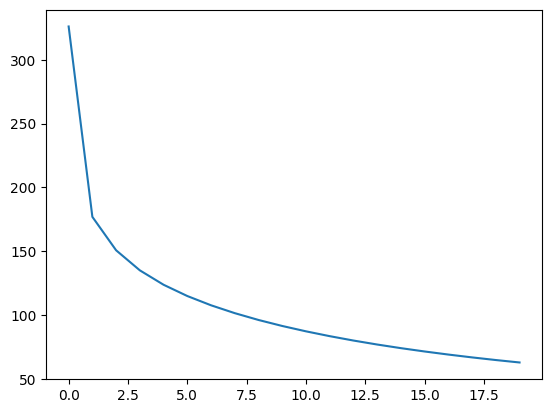

In [6]:
import matplotlib.pyplot as plt

plt.plot(mlp.loss)

In [7]:
# 预测标签
pred = mlp.predict(cp.array(data.iloc[:, :-1].values))
pred = pd.Series(pred.get().squeeze(), index = data.index)
pred.head(5)

code    date      
159901  2019-05-21     8.426320
159902  2019-05-21    -8.383720
159903  2019-05-21     7.845343
159905  2019-05-21    -3.467024
159906  2019-05-21   -21.505425
dtype: float64

In [8]:
# 计算预测值的 IC 表现
ic = pred.unstack().corrwith(data.iloc[:, -1].unstack())
ic.head(5)

date
2019-05-21    0.134870
2019-05-22   -0.024152
2019-05-23    0.149782
2019-05-24   -0.047214
2019-05-27   -0.058712
dtype: float64

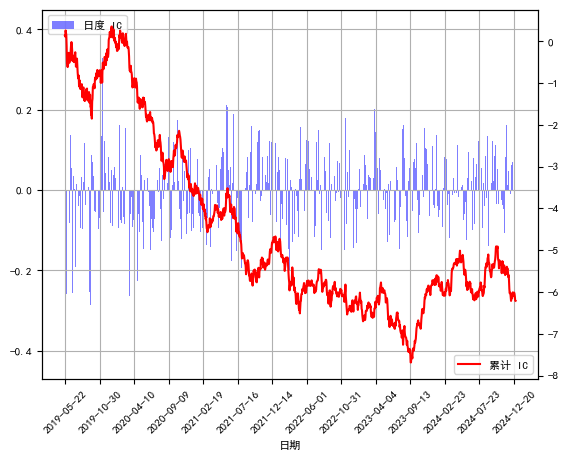

In [9]:
plt.rc("axes", unicode_minus = False)
font = {
    "family": "SimHei",
    "weight": "bold",
    "size": "8"
}
plt.rc("font", **font)

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

# 绘制日度 IC 柱状图
plt.xticks(range(1, len(ic) + 1, 100), rotation = 45)
ax1.bar(ic.index, ic, color = "b", alpha = 0.5, label = "日度 IC")
ax1.grid()
ax1.set_xlabel("日期")
ax1.legend(loc = 2)
# 创建第二个y轴，绘制累计 IC 折线图
cum_ic = ic.cumsum()
ax2 = ax1.twinx()
ax2.plot(cum_ic.index, cum_ic, "-", color = "r", label = "累计 IC")
ax2.legend(loc = 4)

In [10]:
def grouping(
        data: pd.Series = None, 
        group_num: int = 5,
) -> pd.Series:
    
    """
    分组函数

    Parameters
    ----------
    data : 原始数据
    group_num : 分组数

    Returns
    -------
    分组结果
    """

    return pd.qcut(data, group_num, labels = False, duplicates = "drop")

In [11]:
# 将全部 ETF 按照因子表现分 10 组
group_num = 10
groups = pred.groupby("date")
asset_groups = Parallel(n_jobs = -1)(delayed(grouping)(group, group_num) for _, group in groups)
asset_groups = pd.concat(asset_groups)
asset_groups.name = "group"
# 计算分组收益
group_rets = pd.concat([ret, asset_groups], axis = 1)
group_rets = group_rets.groupby(["date", "group"]).mean().unstack()
group_rets.columns = [f"group_{i}" for i in range(group_num)]
group_rets.head(5)

,group_0,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9
date,,,,,,,,,,
2019-05-21,-0.008237,-0.011396,-0.001507,-0.003246,-0.005034,-0.005698,-0.004737,-0.008348,-0.004009,-0.003089
2019-05-22,-0.006735,-0.014216,-0.011410,-0.015718,-0.010109,-0.016337,-0.011567,-0.011355,-0.007258,-0.008967
2019-05-23,-0.006898,-0.006053,-0.002929,-0.000277,0.002477,-0.003166,-0.006956,-0.005434,0.001103,-0.000828
2019-05-24,0.016964,0.012793,0.012580,0.013800,0.013767,0.011622,0.017445,0.014892,0.018391,0.011807
2019-05-27,0.000810,-0.000563,0.000751,-0.000231,0.001779,0.000513,0.000182,-0.000331,-0.000266,-0.001302


In [12]:
# 分组平均收益
mean = group_rets.mean(axis = 0)
mean

group_0    0.000248
group_1    0.000360
group_2    0.000266
group_3    0.000277
group_4    0.000242
group_5    0.000311
group_6    0.000180
group_7    0.000282
group_8    0.000183
group_9    0.000080
dtype: float64

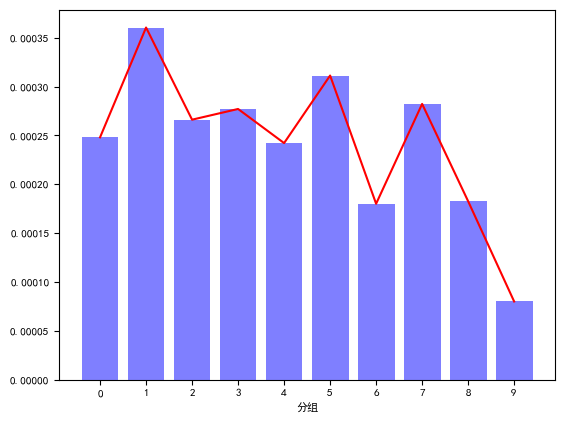

In [ ]:
plt.rc("axes", unicode_minus = False)
font = {
    "family": "SimHei",
    "weight": "bold",
    "size": "8"
}
plt.rc("font", **font)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 绘制日度分组平均收益
plt.xticks(range(group_num))
ax.bar(range(group_num), mean, color = "b", alpha = 0.5)
ax.set_xlabel("分组")
# 绘制日度分组均值收益折线图
ax.plot(range(group_num), mean, "-", color = "r")

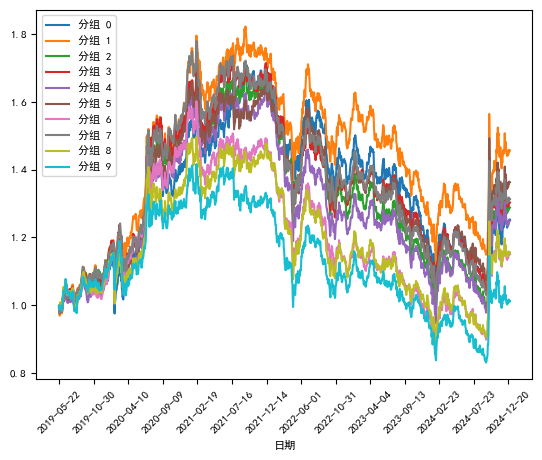

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 绘制日度分组累计收益折线图
plt.xticks(range(1, len(group_rets) + 1, 100), rotation = 45)
ax.plot((1 + group_rets).cumprod(), label = [f"分组 {i}" for i in range(group_num)])
ax.set_xlabel("日期")
ax.legend()

In [ ]:
class MLP:

    """
    MLP 分类算法
    """
    
    def __init__(
            self,
            hidden_size_list: list = []
    ):        
        
        """
        初始化 MLP 分类算法

        Parameters
        ----------
        hidden_size_list : 隐层规模及对应维度
        """
        
        self.hidden_size_list = hidden_size_list

    def shuffle(
            self,
            X: cp.ndarray = None,
            y: cp.ndarray = None,
            random_seed: int = 0
    ) -> tuple[cp.ndarray, cp.ndarray]:
        
        """
        将原始数据集进行随机排序

        Parameters
        ----------
        X : 训练数据集的特征集
        y : 训练数据集的标签集
        random_seed : 随机种子

        Returns
        -------
        X : 训练数据集重排序后的特征集
        y : 训练数据集重排序后的标签集
        """
        
        random.seed(random_seed)
        index = cp.arange(len(X))
        random.shuffle(index)
        X = X[index]
        y = y[index]

        return X, y
    
    def activate_function(
            self,
            X: cp.ndarray = None
    ) -> cp.ndarray:

        """
        激活函数

        Parameters
        ----------
        X : 特征数据集

        Returns
        -------
        value : 对特征数据进行非线性变换后的取值
        """
        
        if self.activate_func == "sigmoid":
            value = 1 / (1 + cp.exp( - X))
        
        elif self.activate_func == "tanh":
            value = (cp.exp(X) - cp.exp( - X)) / (cp.exp(X) + cp.exp( - X))

        elif self.activate_func == "relu":
            value = cp.where(X > 0, X, 0)

        return value
    
    def gradient(
            self,
            X: cp.ndarray = None
    ) -> cp.ndarray:
        
        """
        激活函数的梯度

        Parameters
        ----------
        X : 特征数据集

        Returns
        -------
        value : 特征数据对应激活函数的梯度值
        """
        
        if self.activate_func == "sigmoid":
            value = X * (1 - X)
        
        elif self.activate_func == "tanh":
            value = 1 - X ** 2

        elif self.activate_func == "relu":
            value = cp.where(X > 0, 1, 0)

        return value
    
    def softmax(
            self,
            y: cp.ndarray = None
    ) -> cp.ndarray:

        """
        对神经网络的输出层中间变量进行 softmax 变换得到对应每个标签的概率值

        Parameters
        ----------
        y : 神经网络输出层的中间变量

        Returns
        -------
        vector : 变化后元素为对应每个类别概率的向量
        """
        
        vector = cp.exp(y) / cp.expand_dims(cp.sum(cp.exp(y), axis = 1), axis = 1)
        return vector
    
    def fit(
            self,
            X: cp.ndarray = None,
            y: cp.ndarray = None,
            lr: float = 0.1,
            activate_func: str = "sigmoid",
            batch_size: int = 128,
            epoch_num: int = 100,
            random_seed: int = 0
    ):
        
        """
        拟合训练数据集

        Parameters
        ----------
        X : 训练数据集的特征集
        y : 训练数据集的标签集
        lr : 学习率
        activate_func : 激活函数的类型，可取 "sigmoid"、"tanh" 或 "relu"
        batch_size : 随机梯度下降法更新参数时每一批数据集包含的数据量
        epoch_num : 迭代次数
        random_seed : 随机数种子
        """
        
        self.activate_func = activate_func

        # 训练数据集重排序
        X, y = self.shuffle(X, y, random_seed)
        
        self.loss = list()
        size = len(y)

        # 利用标签数据集构造 one-hot 向量
        y_ = cp.zeros((size, self.hidden_size_list[-1]))
        
        for i in range(self.hidden_size_list[-1]):
            y_[y == i, i] = 1
        
        # 初始化每层隐层的参数后传入 hidden_layer_state
        self.hidden_layer_state = list()
        dim = X.shape[1]
        
        for hidden_size in self.hidden_size_list:
            
            hidden_layer_weight = cp.random.normal(0, 1, (hidden_size, dim))
            hidden_layer_bais = cp.random.normal(0, 1, hidden_size)

            self.hidden_layer_state.append([hidden_layer_weight, hidden_layer_bais])
            dim = hidden_size

        # 拟合训练数据，采用随机梯度下降法更新算法参数
        batch_num = len(X) // batch_size
        X = cp.array_split(X, batch_num)
        y_ = cp.array_split(y_, batch_num)
        
        epoch = 0
        while True:
            
            loss = 0
            for x, y in zip(X, y_):
                
                # 输出层的 delta
                delta = self.predict(x) - y
                
                # 反向更新第 i 层隐层的参数
                for i in range(len(self.hidden_layer_state) - 1, -1, -1):

                    # 前向传播计算第 i 层隐层的输出
                    hidden_out = self.predict(x, i)
                    hidden_out = cp.expand_dims(hidden_out, axis = 1)
                    
                    # 计算参数矩阵和偏置
                    bais_grad = cp.mean(delta, axis = 0)
                    delta = cp.expand_dims(delta, axis = 2)
                    weight_grad = cp.mean(delta * hidden_out, axis = 0)
                    
                    hidden_out = hidden_out.squeeze(1)
                    delta = delta.squeeze(2)

                    hidden_state = self.hidden_layer_state[i]
                    hidden_layer_weight = hidden_state[0]
                    hidden_layer_bais = hidden_state[1]
                    
                    # 更新第 i 层隐层的参数
                    hidden_layer_weight -= lr * weight_grad
                    hidden_layer_bais -= lr * bais_grad

                    hidden_state = [hidden_layer_weight, hidden_layer_bais]

                    self.hidden_layer_state[i] = hidden_state
                    
                    # 更新 delta 得到第 i - 1 层的 delta
                    A = self.gradient(hidden_out)
                    B: cp.ndarray = delta @ hidden_layer_weight
                    delta: cp.ndarray = B.T * A.T
                    delta = delta.T

                loss += self.eval(x, y)

            self.loss.append(loss / batch_num)

            epoch += 1

            if epoch == epoch_num:
                break

    def predict(
            self,
            X: cp.ndarray = None,
            layer_num: int = None,
            proba: bool = True
    ) -> cp.ndarray:
        
        """
        利用 MLP 神经网络进行预测

        Parameters
        ----------
        X : 特征数据集
        layer_num : 将第 layer_num 层隐层视为输出层时的预测情况
        proba : 取 True 时输出向量的每一个元素为该实例对应类别的概率，取 False 时输出实例对应概率最大的类别

        Returns
        -------
        hidden_out : 算法预测值
        """
        
        total_layer_num = len(self.hidden_size_list)
        
        if layer_num is None:
            layer_num = total_layer_num
        
        hidden_out = X

        for i in range(layer_num):
            hidden_state = self.hidden_layer_state[i]
            
            hidden_layer_weight: cp.ndarray = hidden_state[0]
            hidden_layer_bais = hidden_state[1]
            z = hidden_out @ hidden_layer_weight.T + hidden_layer_bais

            if i < layer_num - 1:
                hidden_out = self.activate_function(z)
            else:
                hidden_out = self.softmax(z)
        
        if layer_num == total_layer_num:
            if not proba:
                hidden_out = cp.argmax(hidden_out, axis = 1)

        return hidden_out
    
    def eval(
            self,
            X: cp.ndarray = None,
            y: cp.ndarray = None
    ) -> float:
        
        """
        评估函数，评估损失函数值

        Paramters
        ---------
        X : 数据集的特征集
        y : 数据集的标签集

        Returns
        -------
        loss : 损失函数值
        """
        
        loss = - cp.mean(cp.mean(y * cp.log(self.predict(X)), axis = 1)).get()
        return loss

In [16]:
import numpy as np

In [ ]:
# 标准化后的收益大于零时标记为 1 ，即上涨，否则标记为 0
y_train = pd.Series(np.where(y_train > 0, 1, 0), y_train.index)
y_valid = pd.Series(np.where(y_valid > 0, 1, 0), y_valid.index)
y_train.head(5)

code    date      
159901  2020-01-02    0
159902  2020-01-02    0
159903  2020-01-02    1
159905  2020-01-02    0
159906  2020-01-02    1
dtype: int64

In [18]:
# 实例化 MLP 算法，包含 2 层隐层，神经元数量分别为 128, 1
mlp = MLP([128, 2])
# 拟合训练样本
mlp.fit(cp.array(X_train.values), cp.array(y_train.values), lr = 1e-3, epoch_num = 50, activate_func = "tanh", batch_size = 10000)

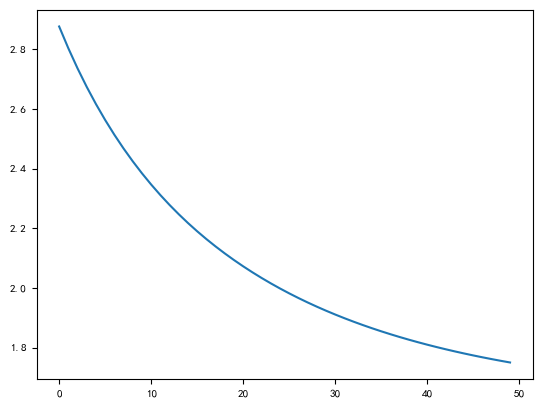

In [ ]:
plt.plot(mlp.loss)

In [20]:
# 预测标签
pred = mlp.predict(cp.array(data.iloc[:, :-1].values), proba = False)
pred = pd.Series(pred.get().squeeze(), index = data.index)
pred.head(5)

code    date      
159901  2019-05-21    0
159902  2019-05-21    0
159903  2019-05-21    1
159905  2019-05-21    1
159906  2019-05-21    1
dtype: int64

In [21]:
# 计算预测值的 IC 表现
ic = pred.unstack().corrwith(data.iloc[:, -1].unstack())
ic.head(5)

date
2019-05-21    0.166494
2019-05-22    0.061487
2019-05-23   -0.074909
2019-05-24    0.092709
2019-05-27    0.048280
dtype: float64

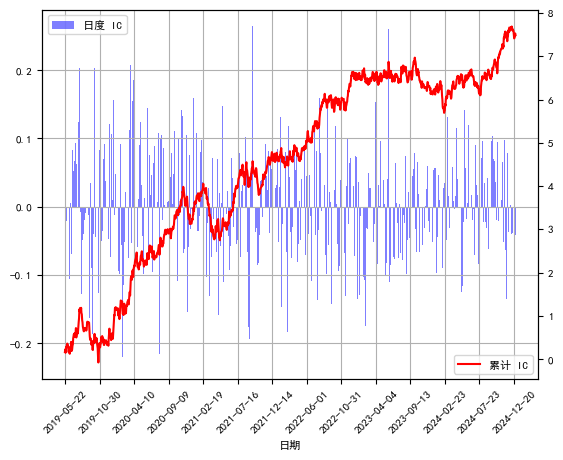

In [22]:
plt.rc("axes", unicode_minus = False)
font = {
    "family": "SimHei",
    "weight": "bold",
    "size": "8"
}
plt.rc("font", **font)

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

# 绘制日度 IC 柱状图
plt.xticks(range(1, len(ic) + 1, 100), rotation = 45)
ax1.bar(ic.index, ic, color = "b", alpha = 0.5, label = "日度 IC")
ax1.grid()
ax1.set_xlabel("日期")
ax1.legend(loc = 2)
# 创建第二个y轴，绘制累计 IC 折线图
cum_ic = ic.cumsum()
ax2 = ax1.twinx()
ax2.plot(cum_ic.index, cum_ic, "-", color = "r", label = "累计 IC")
ax2.legend(loc = 4)

In [ ]:
# 做多预测标签为 1 的资产（预测上涨），做空预测标签为 0 的资产
long = ret[pred == 1].groupby("date").mean()
long.name = "Long"
short = ret[pred == 0].groupby("date").mean()
short.name = "Short"
group_rets = pd.concat([short, long], axis = 1)
group_rets["Long - Short"] = group_rets["Long"] - group_rets["Short"]
group_rets.head(5)

,Short,Long,Long - Short
date,,,
2019-05-21,-0.007351,-0.003919,0.003432
2019-05-22,-0.011903,-0.010535,0.001368
2019-05-23,-0.002304,-0.003754,-0.001450
2019-05-24,0.013511,0.015388,0.001877
2019-05-27,-0.000159,0.000417,0.000576


In [24]:
# 分组平均收益
mean = group_rets.mean(axis = 0)
mean

Short           0.000158
Long            0.000317
Long - Short    0.000160
dtype: float64

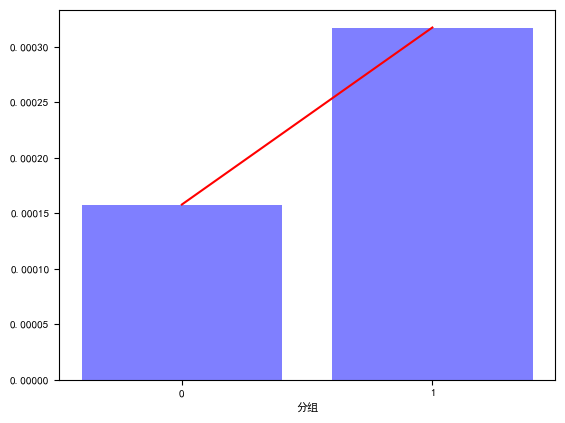

In [25]:
plt.rc("axes", unicode_minus = False)
font = {
    "family": "SimHei",
    "weight": "bold",
    "size": "8"
}
plt.rc("font", **font)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 绘制日度分组平均收益
plt.xticks(range(2))
ax.bar(range(2), mean[:-1], color = "b", alpha = 0.5)
ax.set_xlabel("分组")
# 绘制日度分组均值收益折线图
ax.plot(range(2), mean[:-1], "-", color = "r")

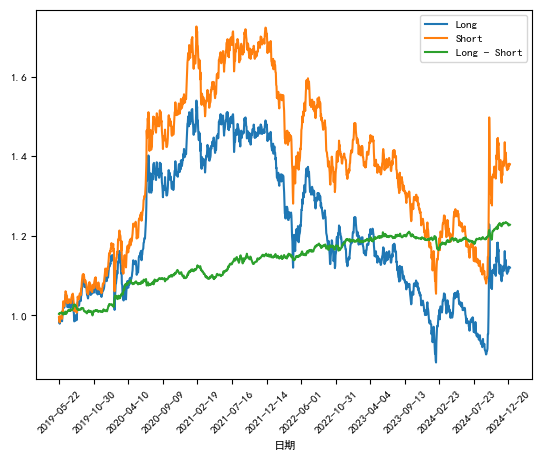

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# 绘制日度分组累计收益折线图
plt.xticks(range(1, len(group_rets) + 1, 100), rotation = 45)
ax.plot((1 + group_rets).cumprod(), label = ["Long", "Short", "Long - Short"])
ax.set_xlabel("日期")
ax.legend()